## Gabriel Marcelino
## Performance Predictions
### January 15, 2025
#### Stock: NVIDIA (NVDA)

### Investment Objective
The investment objective is to analyze if, based on market data for the last few years, there will be 10% increase in the stock price of NVIDIA Corporation (NVDA) over the next four months. This target aligns with a short-term growth strategy, leveraging the company's strong position in the AI, gaming, and data center markets. The objective assumes favorable market conditions, continued demand for NVIDIA's cutting-edge GPUs, and potential revenue growth from its innovative AI solutions. 

1. Import Required Libraries

In [46]:
import csv
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

2. Data set-up and exploration

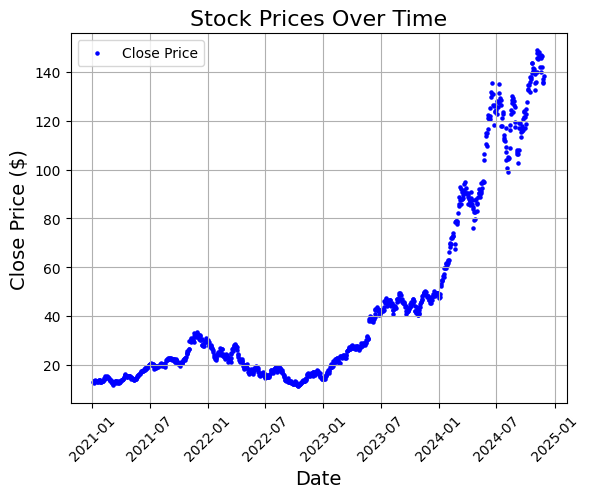

All-Time High Price: $ 148.88
All-Time Low Price: $ 11.227
Average Closing Price: $ 43.712477642276426
Most Recent Closing Price: $ 13.1135


In [47]:
# Load the CSV file
data = pd.read_csv('stock-data.csv')

# Preprocess the data
data['Date'] = pd.to_datetime(data['Date'])  # Convert Date to datetime
data['Close/Last'] = data['Close/Last'].replace({'\$': ''}, regex=True).astype(float)  # Remove $ and convert to float

# Extract X and Y
# X will be days after the first date in the dataset since model can't handle date format
reference_date = data['Date'].min()

# Calculate days since the reference date
data['Days'] = (data['Date'] - reference_date).dt.days

data['7_day_avg'] = data['Close/Last'].rolling(window=7).mean()
data['30_day_avg'] = data['Close/Last'].rolling(window=30).mean()

data = data.dropna()

# Extract X and Y
X = data[['Days', '7_day_avg', '30_day_avg']]  # Multiple features
y= data['Close/Last']

# Plot the data using scatter plot
plt.scatter(data['Date'], y, label='Close Price', color='blue', marker='o', s=5)  

# Add labels and title
plt.title('Stock Prices Over Time', fontsize=16)  # Set title
plt.xlabel('Date', fontsize=14)  # Label for X-axis
plt.ylabel('Close Price ($)', fontsize=14)  # Label for Y-axis
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.grid(True)  # Add grid for better visualization
plt.legend()  # Add legend for clarity
plt.show()  # Display the scatter plot

# Useful info about the data
# Calculate key statistics
all_time_high = data['Close/Last'].max()
all_time_low = data['Close/Last'].min()
average_price = data['Close/Last'].mean()
most_recent_close = data['Close/Last'].iloc[-1]

print("All-Time High Price: $", all_time_high)
print("All-Time Low Price: $", all_time_low)
print("Average Closing Price: $", average_price)
print("Most Recent Closing Price: $", most_recent_close)


3. Prepare training and testing sets, and train model

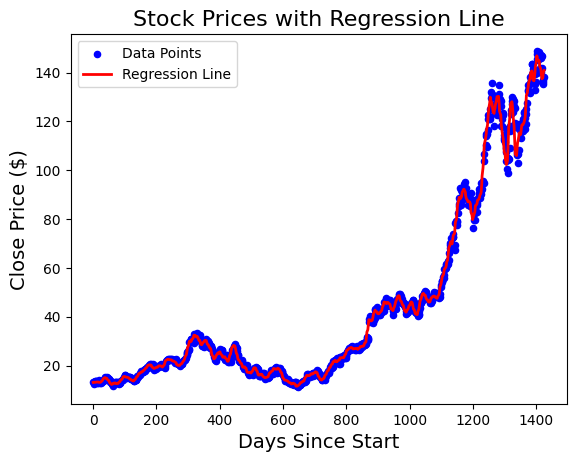

In [51]:
# Split data into training and testing set
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, test_size=0.2)


model = LinearRegression()
model.fit(X_train, y_train)

# Plot the data points
plt.scatter(X['Days'], y, label='Data Points', color='blue', marker='o', s=20)  # Smaller dots for data points

# Generate predictions for the regression line
X_sorted = X.sort_values(by='Days')
y_pred = model.predict(X_sorted)

# Plot the regression line
plt.plot(X_sorted['Days'], y_pred, label='Regression Line', color='red', linewidth=2)  # Red line for regression

# Add labels, title, and legend
plt.title('Stock Prices with Regression Line', fontsize=16)  # Title
plt.xlabel('Days Since Start', fontsize=14)  # X-axis label
plt.ylabel('Close Price ($)', fontsize=14)  # Y-axis label
plt.legend()  # Show legend

plt.show()


4. Improve Model
- Model is overfitting, we can drop variables that are not significant

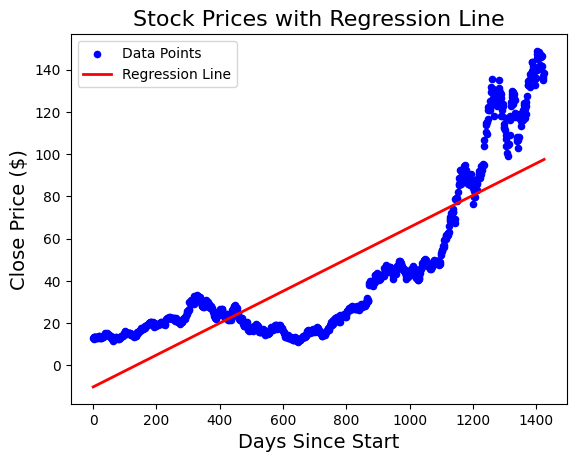

y =  0.07559011489034996 x +  -10.20246906629


In [70]:
X_train_significant = X_train[['Days']]  # Drop '30_day_avg' and '7_day_avg' -> Were making model overfit

# Train the model again with only significant variables (Days)
model = LinearRegression()
model.fit(X_train_significant, y_train)

# Generate predictions for the regression line
X_significant = X_train_significant.sort_values(by='Days')
y_pred = model.predict(X_significant)

# Plot the data points and regression line
plt.scatter(X['Days'], y, label='Data Points', color='blue', marker='o', s=20)  # Smaller dots for data points
plt.plot(X_significant['Days'], y_pred, label='Regression Line', color='red', linewidth=2)  # Red line for regression
plt.title('Stock Prices with Regression Line', fontsize=16)
plt.xlabel('Days Since Start', fontsize=14)
plt.ylabel('Close Price ($)', fontsize=14)
plt.legend()
plt.show()
# Print equation of the line
print("y = ", model.coef_[0], "x + ", model.intercept_)



#### Regression Output Interpretation<br>
Now that we have removed the variables that were causing overfitting, we can interpret the output of the regression model. The model has the following equation:<br>
y =  0.07559011489034996 x +  -10.20246906629<br><br>

This equation represents the relationship between the number of days since the start of the dataset and the closing price of the stock.<br>
The coefficient of x (0.07559011489034996) indicates that for each additional day, the closing price of the stock increases by approximately $0.08.<br>
The intercept term (-10.20246906629) represents the closing price of the stock on the first day of the dataset.<br>
This information can be used to make predictions about the future closing prices of the stock based on the number of days since the start of the dataset.<br>


4. Test Model

In [65]:
from sklearn.metrics import mean_squared_error, r2_score

# Ensure the test set only includes the 'Days' feature
X_test_significant = X_test[['Days']]

# Predict on the test set
y_pred = model.predict(X_test_significant)

# Regression output interpretation
print(f"Coefficient: {model.coef_[0]}")

# Calculate residuals
residuals = y_test - y_pred

# Model evaluation
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"R-squared: {r2}")


Intercept: -10.20246906629
Coefficient: 0.07559011489034996
Mean Squared Error: 459.5398193047663
R-squared: 0.6631708434117585


### Test Results Interpretation
The coefficient of 0.08 indicates that for each additional day, the stock price increases by approximately $0.08. The model has a Mean Squared Error of 459.54, indicating moderate prediction error, and an R-squared value of 0.66, meaning the model explains 66% of the variance in the stock price, which is a decent fit but leaves room for improvement.

5. Final predictions

In [69]:
latest_day = data['Days'].max()  # Most recent day in the dataset
future_day = latest_day + 120  # 4 months later (120 days)

# Make prediction for that day
predicted_price_4_months = model.predict([[future_day]])

print(f"Predicted stock price after 4 months: ${predicted_price_4_months[0]:.2f}")
print(most_recent_close)
print(f"Percentage increase: {((predicted_price_4_months[0] - most_recent_close) / most_recent_close) * 100:.2f}%")



Predicted stock price after 4 months: $106.58
13.1135
Percentage increase: 712.78%


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


## Instructions
Linear Models are a useful measure for technical and quantitative analysis in financial markets.

Given its set of performance characteristics and investment objectives, predict its performance using a linear model.

Then, write a comprehensive technical report as a markdown document, including all code, code comments, all outputs, plots, and analysis, addressing the following. Make sure the project documentation contains a) Problem statement, b) Algorithm of the solution, c) Analysis of the findings and d) References.

Data set-up and exploration
Preparing training and testing sets
Build the multiple linear regression model
Improve the model using only significant variables
Regression output interpretation
Calculate residuals
Make predictions using the test set
Model verification
Final investment worthiness predication results


Statistical analysis provides the pure financial considerations for pursuing a course of action, in this case the choice of investing in a company's stock. From a Christian worldview perspective, describe what other factors you would include in an investment decision process, in addition to statistical and financial ones. Would you include these factors in a quantitative manner as part of a computational model, or would you perform a qualitative assessment of the company separate from the statistical assessment? Justify your answer. To what extent is this decision guided by a Christian worldview?